# Lecture 3: Autodiff in PyTorch

- INFO8010 Deep Learning, Gilles Louppe
- Lecture 3: [Automatic differentiation](https://glouppe.github.io/info8010-deep-learning/?p=lecture3.md)

This notebook demonstrates automatic differentiation using PyTorch's autograd, covering computation graphs, gradient computation, and the forward/backward pass.

In [2]:
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Forward pass and computation graph

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

In [4]:
x = torch.tensor(0.0, requires_grad=True)
y = sigmoid(x)
print(y)

tensor(0.5000, grad_fn=<MulBackward0>)


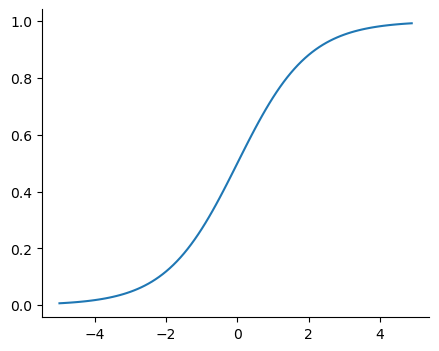

In [5]:
xs = torch.arange(-5, 5, 0.1)
plt.figure(figsize=(5, 4))
plt.plot(xs.numpy(), sigmoid(xs).detach().numpy())
plt.show()

## Inspecting the computation graph

In PyTorch, every tensor produced by a differentiable operation records its `grad_fn`, forming a DAG that `autograd` walks during backpropagation.

We can traverse it manually:

In [6]:
def trace_graph(tensor, indent=0):
    """Recursively print the autograd graph."""
    if tensor.grad_fn is not None:
        print(" " * indent + str(tensor.grad_fn))
        for child, _ in tensor.grad_fn.next_functions:
            if child is not None:
                trace_graph_fn(child, indent + 2)
    elif tensor.requires_grad:
        print(" " * indent + f"leaf: {tensor.data.item():.4f}")

def trace_graph_fn(grad_fn, indent=0):
    """Recurse from a grad_fn node."""
    print(" " * indent + str(grad_fn))
    for child, _ in grad_fn.next_functions:
        if child is not None:
            trace_graph_fn(child, indent + 2)

In [7]:
x = torch.tensor(0.0, requires_grad=True)
y = sigmoid(x)

print("Computation graph for sigmoid(x):")
print()
trace_graph(y)

Computation graph for sigmoid(x):



### Visual graph with torchviz

`torchviz` renders the autograd graph as a Graphviz diagram.

In [12]:
# pip install torchviz
from torchviz import make_dot

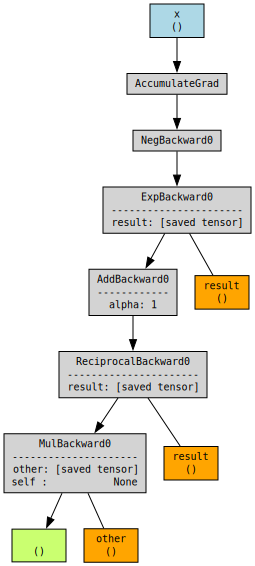

In [13]:
x = torch.tensor(0.0, requires_grad=True)
y = sigmoid(x)

make_dot(y, params={"x": x}, show_attrs=True, show_saved=True)

A more involved example:

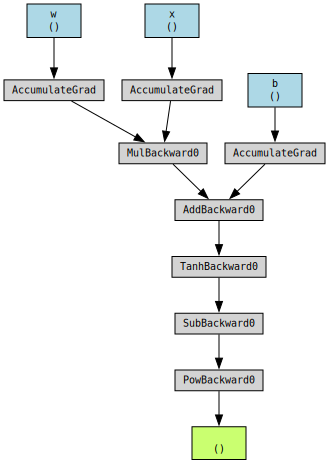

In [14]:
x = torch.tensor(1.5, requires_grad=True)
w = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(-1.0, requires_grad=True)

z = w * x + b
y = torch.tanh(z)
loss = (y - 1.0) ** 2

make_dot(loss, params={"x": x, "w": w, "b": b})

## Gradients via backpropagation

In [15]:
x = torch.tensor(0.0, requires_grad=True)
y = sigmoid(x)
y.backward()

print(f"sigmoid'(0) = {x.grad.item()}")  # should be 0.25

sigmoid'(0) = 0.25


In [16]:
# f = sigmoid
f = torch.tanh

/tmp/ipykernel_1530574/1507498012.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_val, requires_grad=True)


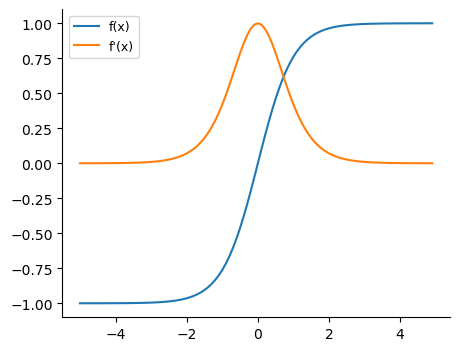

In [ ]:
def grad_f(x_val):
    x = torch.tensor(x_val, requires_grad=True)
    y = f(x)
    y.backward()
    return x.grad.item()  # x.grad now stores dy/dx

xs = torch.arange(-5, 5, 0.1)
fx = [f(xi).item() for xi in xs]
fpx = [grad_f(xi) for xi in xs]

plt.figure(figsize=(5, 4))
plt.plot(xs.numpy(), fx, label="f(x)")
plt.plot(xs.numpy(), fpx, label="f'(x)")
plt.legend(fontsize=9)
plt.show()

## Higher-order derivatives

PyTorch supports higher-order gradients via `create_graph=True`, which builds a graph of the gradient computation itself.

In [18]:
def nth_derivative(f, x_val, n=1):
    """Compute the n-th derivative of f at x_val."""
    x = torch.tensor(x_val, requires_grad=True)
    y = f(x)
    for i in range(n):
        y = torch.autograd.grad(y, x, create_graph=True)[0]
    return y.item()

print(f"f'(0)   = {nth_derivative(f, 0.0, 1)}")
print(f"f''(0)  = {nth_derivative(f, 0.0, 2)}")
print(f"f'''(0) = {nth_derivative(f, 0.0, 3)}")

f'(0)   = 1.0
f''(0)  = -0.0
f'''(0) = -2.0


/tmp/ipykernel_1530574/3267623046.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_val, requires_grad=True)


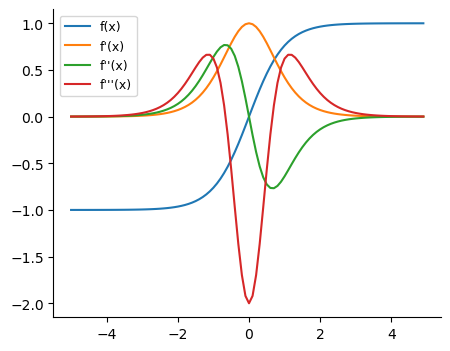

In [19]:
xs = torch.arange(-5, 5, 0.1)

plt.figure(figsize=(5, 4))
plt.plot(xs.numpy(), [f(xi).item() for xi in xs], label="f(x)")
plt.plot(xs.numpy(), [nth_derivative(f, xi, 1) for xi in xs], label="f'(x)")
plt.plot(xs.numpy(), [nth_derivative(f, xi, 2) for xi in xs], label="f''(x)")
plt.plot(xs.numpy(), [nth_derivative(f, xi, 3) for xi in xs], label="f'''(x)")
plt.legend(fontsize=9)
plt.show()

## Inspecting the graph of higher-order derivatives

Each call to `torch.autograd.grad(..., create_graph=True)` extends the graph. We can visualize how the graph grows with each derivative order.

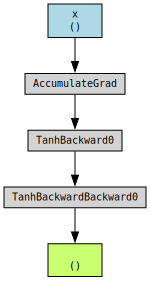

In [20]:
x = torch.tensor(0.0, requires_grad=True)
y = f(x)

fp = torch.autograd.grad(y, x, create_graph=True)[0]
make_dot(fp, params={"x": x})

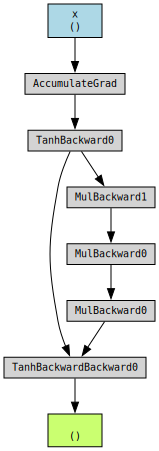

In [21]:
fpp = torch.autograd.grad(fp, x, create_graph=True)[0]
make_dot(fpp, params={"x": x})

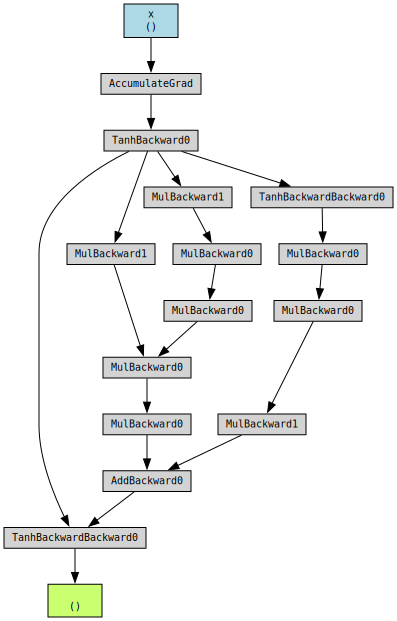

In [22]:
fppp = torch.autograd.grad(fpp, x, create_graph=True)[0]
make_dot(fppp, params={"x": x})

Notice how each derivative order adds more nodes — the graph of f'''(x) is substantially larger than f'(x). This is the autodiff graph being differentiated through itself.